# Throttling handling demo (using live server)

## Scenarios:
1. discard the rejected request altogether
1. retry with active waiting until success or maximum retry number has been reached
1. put the request on a background queue that is periodically processed by background worker while we continue execution

## Initializing API client and query object

In [1]:
import os
import sys
import logging
import pandas as pd
from threading import Thread, Event

from io import BytesIO
from PIL import Image
from datetime import datetime
from kentik_api.public.errors import IntermittentError
from kentik_api.throttling.cmd import Cmd 
from kentik_api.throttling.active_wait_retry import active_wait_retry
from kentik_api.throttling.background_queue import BackgroundCmdQueue
from kentik_api import (
    KentikAPI,
    QueryObject,
    QuerySQL,
    QueryArrayItem,
    Query,
    Aggregate,
    AggregateFunctionType,
    FastDataType,
    MetricType,
    DimensionType,
    ImageType,
    ChartViewType,
)
from kentik_api.utils import get_credentials

logging.basicConfig(level=logging.ERROR, stream=sys.stdout) # for throttling observability


email, token = get_credentials()
client = KentikAPI(email, token)

agg1 = Aggregate(name="avg_bits_per_sec", column="f_sum_both_bytes", fn=AggregateFunctionType.average, raw=True)
agg2 = Aggregate(name="p95th_bits_per_sec", column="f_sum_both_bytes", fn=AggregateFunctionType.percentile, rank=95)
agg3 = Aggregate(name="max_bits_per_sec", column="f_sum_both_bytes", fn=AggregateFunctionType.max)

query = Query(
    dimension=[DimensionType.Traffic],
    cidr=32,
    cidr6=128,
    metric=MetricType.bytes,
    topx=8,
    depth=75,
    fastData=FastDataType.auto,
    outsort="avg_bits_per_sec",
    overlay_day=-7,
    show_overlay=False,
    sync_axes=False,
    viz_type=ChartViewType.stackedArea,
    lookback_seconds=3600,
    hostname_lookup=True,
    device_name=[],
    matrixBy=[],
    all_selected=True,
    filters_obj=None,
    descriptor="",
    aggregates=[agg1, agg2, agg3],
)

query_item = QueryArrayItem(query=query, bucket="Left +Y Axis", isOverlay=False)
query_object = QueryObject(queries=[query_item], imageType=ImageType.png)

def repeat_until_limit_exceeded(cmd):
    print("Repeating the request until API responds with an error")
    
    stop = Event()
    threads = list()
    
    def stop_loop():
        if not stop.is_set():
            print("")
            stop.set()
            
    def run_loop():
        try:         
            for _ in range(20):
                if stop.is_set():
                    break
                print(".", end="")
                cmd.execute()
        except IntermittentError as err:
            stop_loop()
            print(err)
            
    # run worker threads    
    for _ in range(10):
        t = Thread(target=run_loop, daemon=True)
        threads.append(t)
        t.start()
        
    # wait until worker threads finish
    for t in threads:
        t.join()
        
    print("Finished repeating the request")

## Warm up - successful request

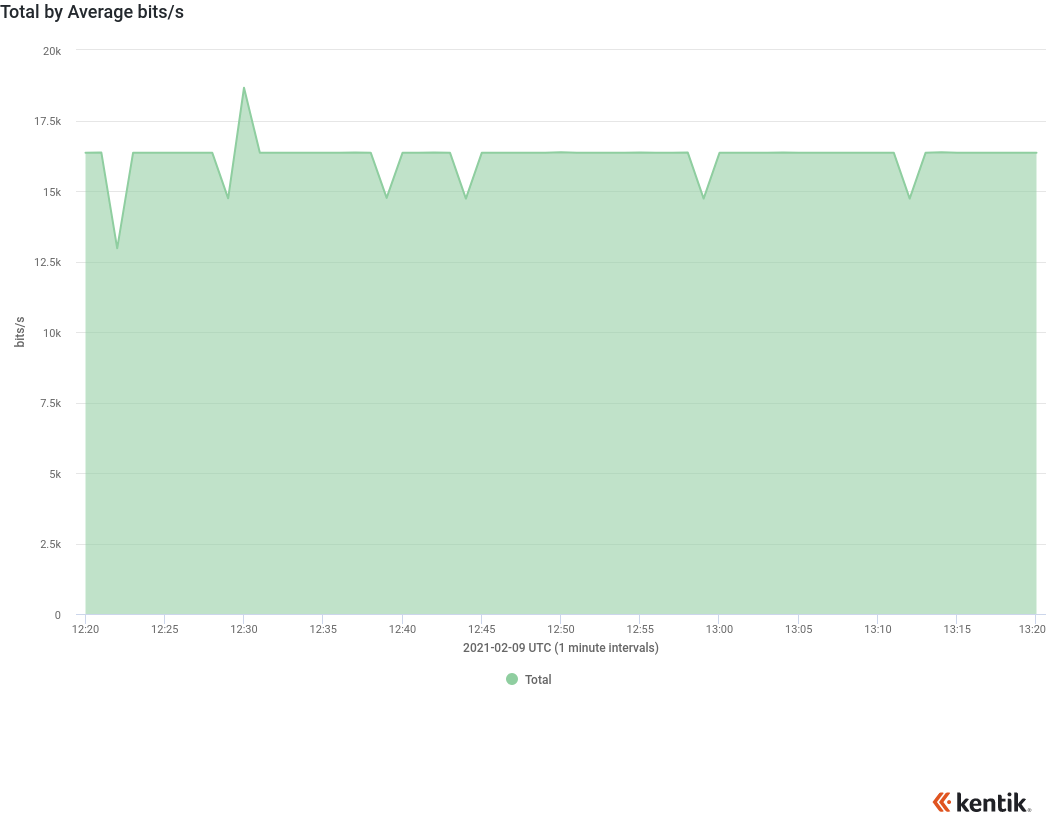

In [2]:
result = client.query.chart(query_object)
img = Image.open(BytesIO(result.get_data()))
img

## Scenario 1: discard the failed request

In [3]:
try:
    result = client.query.chart(query_object)
    print("Success")
except IntermittentError as err:
    # in case of error - just discard the request
    print("Error. Discarding request")

Success


## Scenario 2: retry actively waiting for the outcome

Repeating the request until API responds with an error
.............
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)


HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)

HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
Finished repeating the request


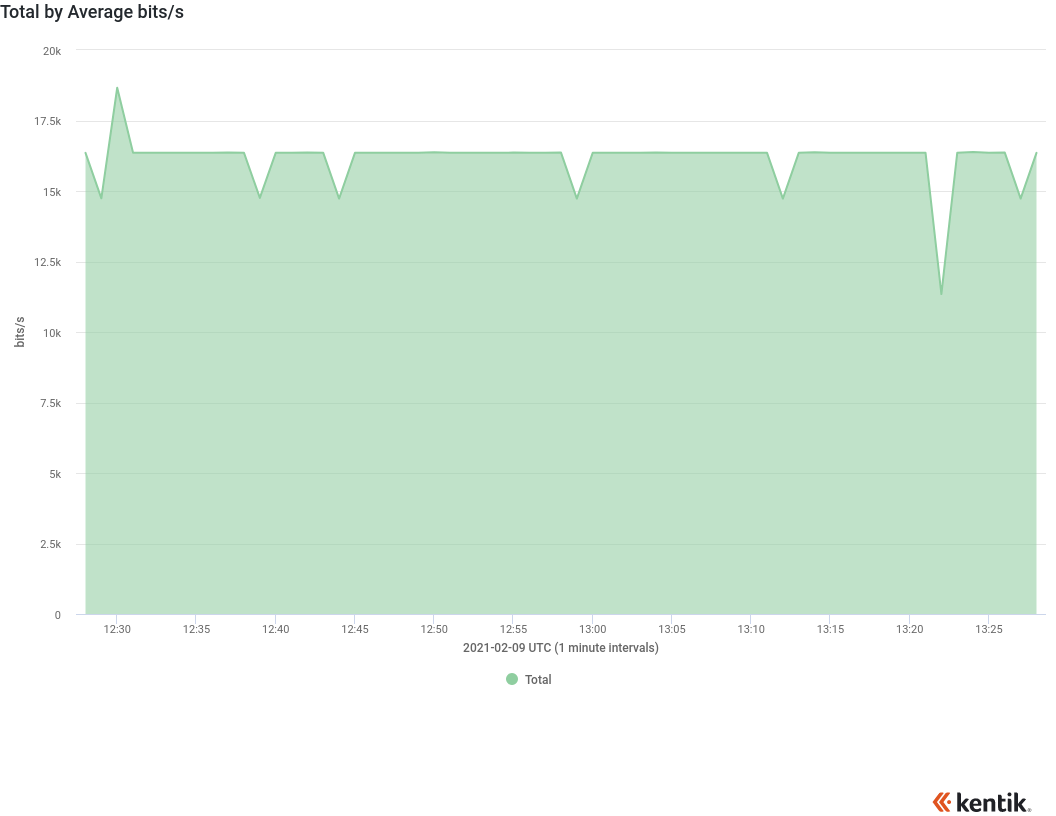

In [4]:
query_chart_cmd = Cmd(method=client.query.chart, query=query_object)

# exceed the API request limit
repeat_until_limit_exceeded(cmd=query_chart_cmd)

# then retry with delay
result = active_wait_retry(cmd=query_chart_cmd, num_attempts=30, retry_delay_seconds=5.0)

img = Image.open(BytesIO(result.get_data()))
img

## Scenario 3: delegate retry to a background worker and continue processing

Repeating the request until API responds with an error
.............
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
HTTPSConnectionPool(host='api.kentik.com', port=443): Read timed out. (read timeout=30.0)
Finished repeating the request
ERROR:kentik_api.throttling.background_queue:request failed with "HTTPSConnectionPool(host

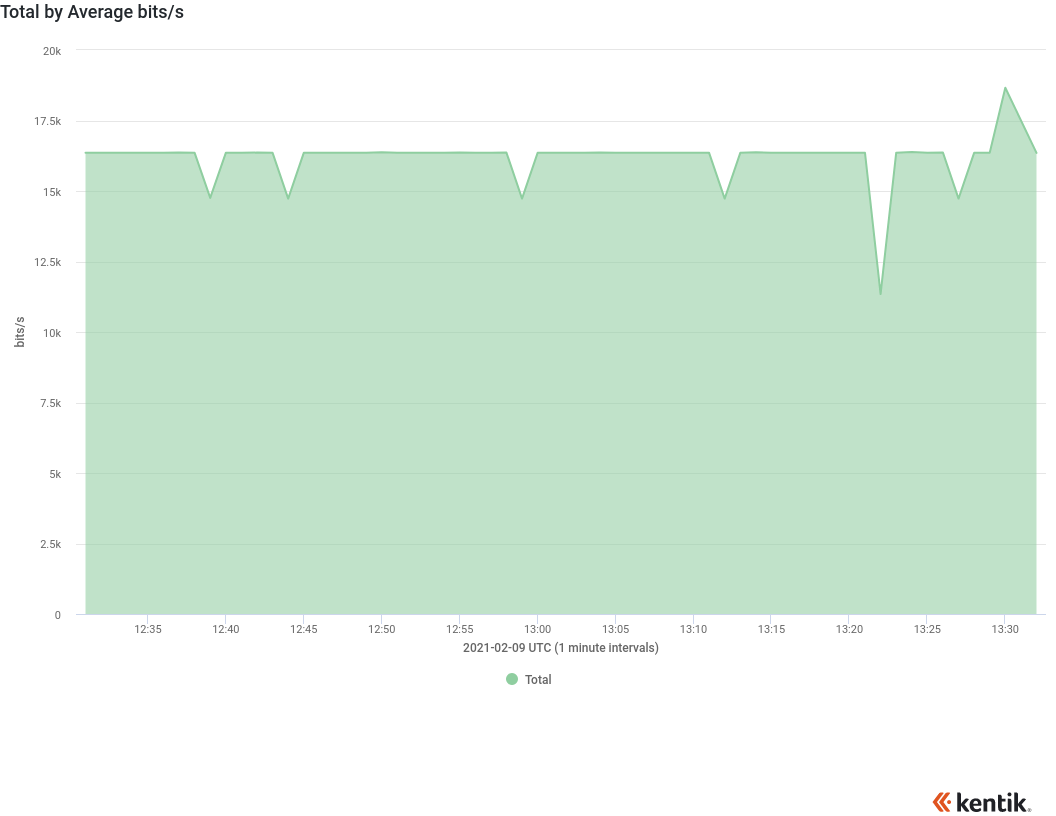

In [5]:
# command execution success handler
def success(result):
    print("request successfull. Received image type:", result.image_type)
    global img 
    img = Image.open(BytesIO(result.get_data()))

# command execution abort handler - all attempts exhausted    
def abort(error):
    print("request aborted: " + str(error))

query_chart_cmd = Cmd(method=client.query.chart, query=query_object)

# exceed the API request limit
repeat_until_limit_exceeded(cmd=query_chart_cmd)

# then retry with delay, in background thread
queue = BackgroundCmdQueue(retry_delay_seconds=5.0)
queue.put(cmd=query_chart_cmd, num_attempts=30, on_success=success, on_abort=abort)

# block foreground thread; background worker is doing it's background work
_ = input()
img